----
# SVM classification using sklearn
----

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import confusion_matrix as skconfmatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys

# Set correct working directory
if os.getcwd() != os.path.abspath("../Python"):
    os.chdir("../../Python")

# Import files from /Python directory
from confusion_matrix import confusion_matrix,false_info

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})

In [2]:
# Load data sets
trn_data = pd.read_csv(f"../TrainingData/neodata/soltani_14d_nonoise_1200.csv")
vld_data = pd.read_csv(f"../ValidationData/neodata/soltani_14d_nonoise_1200.csv")
tst_data = pd.read_csv(f"../TestData/neodata/soltani_14d_nonoise_100.csv")
trn_data = trn_data.iloc[::10,:]

# Separate into data and targets
y_trn = trn_data.pop('target')
X_trn = trn_data
print(y_trn)

y_vld = vld_data.pop('target')
X_vld = vld_data

y_tst = tst_data.pop('target')
X_tst = tst_data

0         0
10        0
20        0
30        0
40        0
         ..
25150    20
25160    20
25170    20
25180    20
25190    20
Name: target, Length: 2520, dtype: int64


# Extract and keep only class 0, 8 and 8

In [3]:
X_trn = X_trn[(y_trn == 0) | (y_trn == 8) | (y_trn == 18)]
y_trn = y_trn[(y_trn == 0) | (y_trn == 8) | (y_trn == 18)]

X_tst = X_tst[(y_tst == 0) | (y_tst == 8) | (y_tst == 18)]
y_tst = y_tst[(y_tst == 0) | (y_tst == 8) | (y_tst == 18)]

X_vld = X_vld[(y_vld == 0) | (y_vld == 8) | (y_vld == 18)]
y_vld = y_vld[(y_vld == 0) | (y_vld == 8) | (y_vld == 18)]

In [4]:
X_trn = X_trn.drop(columns=['Density','CprPower','Psuc'])
X_tst = X_tst.drop(columns=['Density','CprPower','Psuc'])
X_vld = X_vld.drop(columns=['Density','CprPower','Psuc'])
X_trn.head()

,Pdis,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,Tamb,Tset
0,8.931735,-7.327275,35.250968,62.398172,9.213731,5.218196,12.545463,-0.007051,91.677418,30,0
10,8.305619,3.273855,32.650593,42.607281,14.157928,10.027551,6.753701,7.010487,62.784366,30,7
20,9.065025,-8.298837,35.786750,65.200167,9.649841,5.515914,13.814733,-0.018808,97.630555,20,0
30,7.953924,-2.567634,31.124694,46.600644,5.161695,3.144239,5.711873,0.004178,45.829937,10,0
40,8.087326,-3.011530,31.709352,48.406431,5.810716,3.424835,6.436364,0.003500,52.326137,20,0


## Standardize data

In [5]:
# Use standard scaler for scaling
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()

# Use PCA sphering/whitening for scaling
# from sklearn.decomposition import PCA
# standardizer = PCA(whiten=True)

X_trn = pd.DataFrame(standardizer.fit_transform(X_trn), columns = X_trn.columns)
X_vld = pd.DataFrame(standardizer.transform(X_vld), columns = X_trn.columns)
X_tst = pd.DataFrame(standardizer.transform(X_tst), columns = X_trn.columns)
X_trn.insert(len(X_trn.columns), 'target', y_trn.to_numpy())
X_vld.insert(len(X_vld.columns), 'target', y_vld.to_numpy())
X_tst.insert(len(X_tst.columns), 'target', y_tst.to_numpy())
print(X_trn)

         Pdis        T0        Tc      Tdis      Tret      Tsuc       Tsh  \
0    0.318048 -1.343842  0.345964  1.112158 -0.835994 -0.980200  0.818793   
1   -0.661961  0.621720 -0.654391 -0.823968 -0.008296  0.117741 -0.785286   
2    0.526674 -1.523980  0.552077  1.386275 -0.762986 -0.912233  1.170329   
3   -1.212439 -0.461354 -1.241399 -0.433301 -1.514337 -1.453669 -1.073829   
4   -1.003637 -0.543657 -1.016483 -0.256642 -1.405685 -1.389611 -0.873175   
..        ...       ...       ...       ...       ...       ...       ...   
355 -0.751735  0.658017 -0.748825 -0.898585 -0.053461  0.099362 -0.861804   
356  1.871405  0.444020  1.828670  0.711930  1.801819  1.494808  1.150775   
357 -0.497787  1.475439 -0.482940 -1.212346  0.949033  1.152482 -0.805217   
358  1.180530 -0.338500  1.183644  0.882753  0.650080  0.493651  1.105094   
359 -0.898846 -0.589119 -0.904654 -0.164751 -1.354241 -1.358382 -0.767379   

         Tsup   CondFan      Tamb      Tset  target  
0   -1.181377  0.7500

Preserving 100.0% of variance


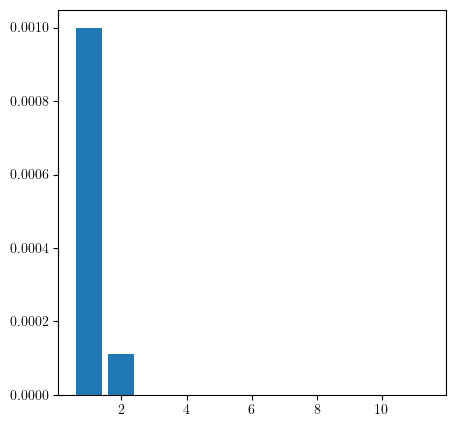

In [6]:
from lda import LDA_reducer

LDA = LDA_reducer(X_trn, 2,'target')
X_trn = LDA.transform(X_trn)
X_vld = LDA.transform(X_vld)
X_tst = LDA.transform(X_tst)


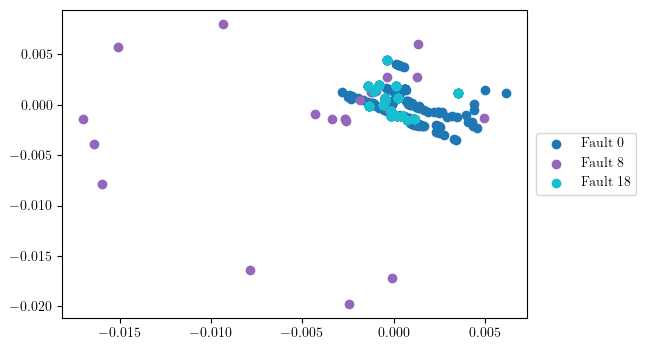

In [7]:
from plot_functions import plot_transformation
plot_transformation(X_trn, plt_show= True)

X_trn = X_trn.drop('target', axis = 1)
X_vld = X_vld.drop('target', axis = 1)
X_tst = X_tst.drop('target', axis = 1)

---

# SVM fitting

In [8]:
# Setup axis ticks with classes removed
ticks = [[x for x in range(len(y_trn.unique()))],y_trn.unique()]

In [9]:
# Training the SVM, on the 5 dimensional data
from sklearn import svm
from sklearn.model_selection import GridSearchCV, PredefinedSplit,GroupKFold

svc = svm.SVC()
C_params = [10**x for x  in np.linspace(2,4, 31)]
gamma_params = [10**x for x  in np.linspace(-2,0, 31)]
clf = GridSearchCV(svc, {'decision_function_shape':['ovo'], 'C' : C_params, 'gamma' : gamma_params}, n_jobs = -1, verbose = 3.5)

clf.fit(X_trn,y_trn)
print(clf.best_estimator_)

Fitting 5 folds for each of 961 candidates, totalling 4805 fits
SVC(C=7356.422544596414, decision_function_shape='ovo', gamma=1.0)


# Classifying training data

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'SVM on training set for faults 0, 8 and 18 : Accuracy 46.111%'}, xlabel='Predicted class', ylabel='True class'>)

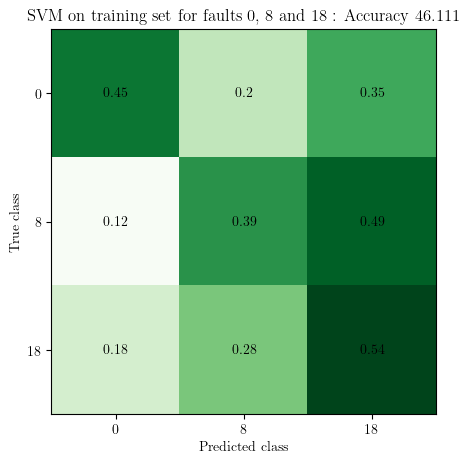

In [10]:
# Make predictions for the training set
y_hat_trn = clf.predict(X_trn)

# plot the confusion matrix
conf_matrix_trn = skconfmatrix(y_trn,y_hat_trn)
confusion_matrix(conf_matrix_trn, figsize = (5,5),axis_ticks = ticks,title='SVM on training set for faults 0, 8 and 18')

# Classifying validation data

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'SVM on validation set for faults 0, 8 and 18 : Accuracy 46.611%'}, xlabel='Predicted class', ylabel='True class'>)

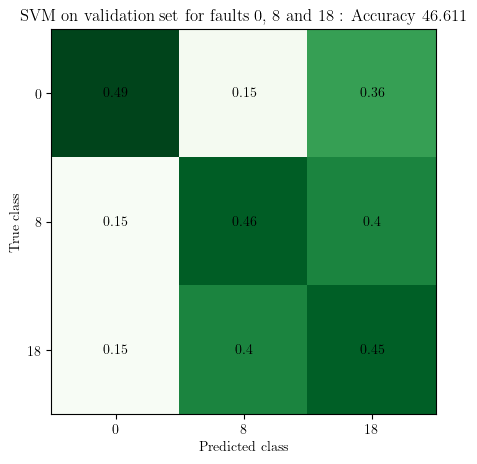

In [11]:
# Make predictions for the training set
y_hat_vld = clf.predict(X_vld)

#plot the confusion matrix
conf_matrix_vld = skconfmatrix(y_vld,y_hat_vld)
confusion_matrix(conf_matrix_vld, figsize = (5,5),axis_ticks = ticks,title='SVM on validation set for faults 0, 8 and 18',save_fig_name = sys.path[0] + "/faults_0_8_18_plots/Full_SVM_validation_rm_8_18.pdf")

# Classifying test data

c:\Users\bosto\Documents\GitHub\p7-ml-refrigeration-fault-detection\ClassificationScripts\AlternativeTechniques


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'SVM on test set for faults 0, 8 and 18 : Accuracy 33.333%'}, xlabel='Predicted class', ylabel='True class'>)

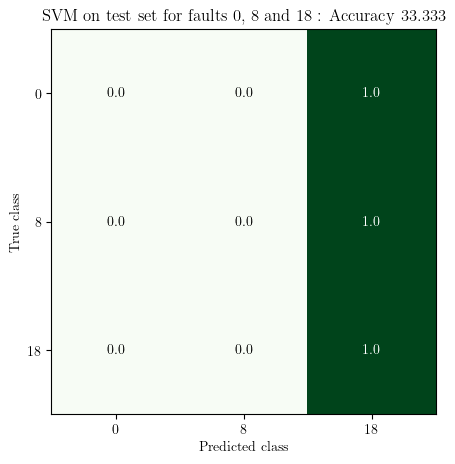

In [12]:
# Make predictions for the training set
y_hat_tst = clf.predict(X_tst)

#plot the confusion matrix
print(sys.path[0])
conf_matrix_vld = skconfmatrix(y_tst,y_hat_tst)
confusion_matrix(conf_matrix_vld, figsize = (5,5),axis_ticks = ticks,title='SVM on test set for faults 0, 8 and 18',save_fig_name = sys.path[0] + "/faults_0_8_18_plots/Full_SVM_test_rm_8_18.pdf")